<a href="https://colab.research.google.com/github/Adriana-Oliveir/ProjetoMarcato/blob/main/PL_Unico%2C_PDD_e_PDDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PL UNICO, PDD e PDDD
### Trabalho 4 - Planejamento de Sistemas Elétricos
### PPEE - UFJF

Professor: André Marcato \\
Aluna: Adriana Oliveira de Mendonça

Importação das bibliotecas necessárias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op
from itertools import product, tee
from matplotlib import cm
import time

# PL Único - Programação Linear Único

## Definição dos Dados do Problema

Usinas Hidrelétricas, termelétricas e dados gerais do sistema

In [3]:
lista_uhe = []

usina = {
    "Nome": "Hidrelétrica 1", # Nome da Usina
    "Vmax": 100.,             # Volume Máximo em hm^3
    "Vmin": 20.,              # Volume Mínimo em hm^3
    "VI": 60.,                # Volume Inicial em hm^3
    "Prod": 0.95,             # Produtibilidade em MWmed/hm^3
    "Engol": 60.,             # Engolimento Máximo em hm^3
    "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
           [26.64],  # janeiro
           [11.655],  # fevereiro
           [17.945],  # março
           ]
}

lista_uhe.append(usina)

usina = {
    "Nome": "Termelétrica 1",     # Nome da Usina Térmica 1
    "Capac": 20.,                 # Capacidade Máxima de Geração MWMed
    "Custo": 10.                  # Custo de Operação $/MWMed
}

lista_ute = []

lista_ute.append(usina)

usina = {
    "Nome": "Termelétrica 2",     # Nome da Usina Térmica 2
    "Capac": 15.,                 # Capacidade Máxima de Geração MWmed
    "Custo": 25.                  # Custo de Operação $/MWMed
}

lista_ute.append(usina)

usina = {
    "Nome": "Termelétrica 3",     # Nome da Usina Térmica 3
    "Capac": 10.,                 # Capacidade Máxima de Geração MWmed
    "Custo": 35.                  # Custo de Operação $/MWMed
}

lista_ute.append(usina)

#
# d_gerais para o caso 1 UHE
#
d_gerais = {
    "CDef": 1000.,             # Custo de Déficit $/MWMed
    "Carga": [ 50., 50., 50.], # Lista com carga a ser atendida por estágio
    "Nr_Disc": 50,             # Número de Discretizações
    "Nr_Est": 3,               # Número de Estágios
    "Nr_Cen": 1                # Número de Cenários de Afluências
}


sistema = {
    "DGer": d_gerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}


## Modelo de Otimização

## Criação de uma Função para o Despacho Hidrotérmico

**Função Objetivo (FOB)**

$		Min \sum_{i=1}^{Nr\_EST} \left( \left( \sum_{j=1}^{Nr\_UTE}  CO_j \cdot gt_{i,j}\right) + CDEF \cdot def_{i} + \left( \sum_{j=1}^{Nr\_UHE}  0.01 \cdot vv_{i,j}\right) \right) $

**sujeito a:**

**Balanço Hídrico (uma restrição para cada estágio $i$ e UHE $j$)**

Caso $ i == 1 $:

$ v_{f_{1,j}} = VI_j + AFL_{1,j} - v_{t_{1,j}} - v_{v_{1,j}} $

Caso $ i \ge 2 $:

$ v_{f_{i,j}} = v_{f_{i-1,j}} + AFL_{i,j} - v_{t_{i,j}} - v_{v_{i,j}} $

**Atendimento à Demanda (uma restrição para cada estágio $i$)**

$ \sum_{j}^{Num\_UHE} \left( \rho_j \cdot v_{t_{i,j}} \right) +
				\sum_{j}^{Num\_UTE}	\left( g_{t_{i,j}} \right) + def_i = CARGA_i $

**Restrições de Canalização:**

Para cada estágio $i$ e UHE $j$:

$VMIN_j \ge v_{f_{i,j}} \ge VMAX_j $

$0 \ge v_{t_{i,j}} \ge ENGOL_j$

$0 \ge v_{v_{i,j}} \ge \infty $

Para cada estágio $i$ e UTE $j$:

$0 \ge g_{t_{i,j}} \ge GTMAX_j $

Para cada estágio $i$:

$ 0 \ge def_i \ge \infty $


In [4]:
def pl_unico(sistema, cenario, imprime):

  #
  # Cria função de despacho hidrotérmico
  #

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão Organizadas Matricialmente
  # Exemplo de acesso à variável de decisão de volume final
  # vf[usina][estagio]
  #

  vf = []
  vt = []
  vv = []
  for i,iusi in enumerate(sistema["UHE"]):
    vf.append(variable(sistema["DGer"]["Nr_Est"], "Volume Final na Usina "+iusi["Nome"]))
    vt.append(variable(sistema["DGer"]["Nr_Est"], "Volume Turbinado na Usina "+iusi["Nome"]))
    vv.append(variable(sistema["DGer"]["Nr_Est"], "Volume Vertido na Usina "+iusi["Nome"]))
  gt = []
  for i,iusi in enumerate(sistema["UTE"]):
    gt.append(variable(sistema["DGer"]["Nr_Est"], "Geração na Usina Térmica "+iusi["Nome"]))
  deficit = variable(sistema["DGer"]["Nr_Est"], "Déficit de Energia no Sistema")

  #
  # Construção da Função Objetivo
  #

  fob = 0

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UTE"]):
      fob += iusi['Custo']*gt[i][i_est]

    fob += sistema["DGer"]["CDef"]*deficit[i_est]

    for i, iusi in enumerate(sistema["UHE"]):
      fob += 0.01*vv[i][i_est]

  #
  # Definição das Restrições
  #

  restricoes = []

  #
  # Balanço Hídrico
  #

  for i, iusi in enumerate(sistema["UHE"]):
    for i_est in range(sistema["DGer"]["Nr_Est"]):
      if i_est == 0:
        restricoes.append( vf[i][i_est] == float(iusi["VI"]) + float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est])
      else:
        restricoes.append( vf[i][i_est]  ==  vf[i][i_est-1]  + float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est])

  #
  # Atendimento à Demanda
  #

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    AD = 0
    for i,usi in enumerate(sistema["UHE"]):
      AD += iusi["Prod"]*vt[i][i_est]
    for i,usi in enumerate(sistema["UTE"]):
      AD += gt[i][i_est]
    AD += deficit[i_est]
    restricoes.append( AD == sistema["DGer"]["Carga"][i_est])


  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UHE"]):
      restricoes.append(vf[i][i_est] >= iusi["Vmin"])
      restricoes.append(vf[i][i_est] <= iusi["Vmax"])
      restricoes.append(vt[i][i_est] >= 0)
      restricoes.append(vt[i][i_est] <= iusi["Engol"])
      restricoes.append(vv[i][i_est] >= 0)
    for i, iusi in enumerate(sistema["UTE"]):
      restricoes.append(gt[i][i_est] >= 0)
      restricoes.append(gt[i][i_est] <= iusi["Capac"])
    restricoes.append(deficit[i_est] >= 0)

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  #
  # Prepara dicionário de dados com resultados
  #

  lista_uhe = []
  for i, iusi in enumerate(sistema["UHE"]):
    pula = i*sistema["DGer"]["Nr_Est"]
    cma = []
    volf = []
    volt = []
    volv = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      cma.append(restricoes[pula+i_est].multiplier.value[0])
      volf.append(vf[i][iest].value()[0])
      volt.append(vt[i][iest].value()[0])
      volv.append(vv[i][iest].value()[0])
    elemento = {
        "vf": volf,
        "vt": volt,
        "vv": volv,
        "cma": cma
    }
    lista_uhe.append(elemento)

  lista_ute = []
  for i, iusi in enumerate(sistema["UTE"]):
    gerter = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      gerter.append(gt[i][iest].value()[0])
    elemento = {
        "gt": gerter,
    }
    lista_ute.append(elemento)

  pula = Num_UHE*sistema["DGer"]["Nr_Est"]
  cmo = []
  for i_est in range(sistema["DGer"]["Nr_Est"]):
    cmo.append(restricoes[pula+i_est].multiplier.value[0])

  Dger = {
      "CustoTotal": fob.value()[0],
      "CMO": cmo
  }

  resultado = {
    "DGer": Dger,
    "UHE": lista_uhe,
    "UTE": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime:
    print("Custo de Operação de Todos os estágios:", fob.value())

    print("Volume Final por UHE em cada Estágio em (hm^3) ")
    for i,usi in enumerate(sistema["UHE"]):
      print(vf[i])
      print(vt[i])
      print(vv[i])

    print("Geração por UTE em cada Estágio em (MWMed)")
    for i,usi in enumerate(sistema["UTE"]):
      print(gt[i])

    print("Déficit de Energia em cada Estágio em (MWMed)")
    print(deficit)

    print("----- x ------ ")

  return(resultado)


## Programa Principal

In [5]:
inicio =  time.time()
resultado_pl = pl_unico(sistema, 0, imprime=False)
tempo_pl = time.time() - inicio
print(resultado_pl)
print('Tempo: ',time.time() - inicio, 'segundos')

{'DGer': {'CustoTotal': 585.7199999999999, 'CMO': [-9.999999999999998, -9.999999999999998, -9.999999999999998]}, 'UHE': [{'vf': [53.557894736842115, 33.633947368421055, 20.0], 'vt': [33.08210526315789, 31.57894736842106, 31.578947368421055], 'vv': [0.0, 0.0, 0.0], 'cma': [9.499999999999998, 9.499999999999998, 9.499999999999998]}], 'UTE': [{'gt': [18.572000000000006, 20.0, 20.0]}, {'gt': [0.0, -3.552713678800501e-15, 0.0]}, {'gt': [0.0, 0.0, 0.0]}]}
Tempo:  0.05461835861206055 segundos


In [6]:
CustoTotal_PL = (resultado_pl['DGer']['CustoTotal'])
UHE_vf_PL = (resultado_pl['UHE'][0]['vf'])

#PDDD - Programação Dinâmica Dual Determinística

##Modelo de Otimização

**Função Objetivo (FOB)**

$		Min \sum_{i=1}^{Nr\_EST} \left( \left( \sum_{j=1}^{Nr\_UTE}  CO_j \cdot gt_{i,j}\right) + CDEF \cdot def_{i} + \left( \sum_{j=1}^{Nr\_UHE}  0.01 \cdot vv_{i,j}\right) \right) $

**sujeito a:**

**Balanço Hídrico (uma restrição para cada estágio $i$ e UHE $j$)**

Caso $ i == 1 $:

$ v_{f_{1,j}} = VI_j + AFL_{1,j} - v_{t_{1,j}} - v_{v_{1,j}} $

Caso $ i \ge 2 $:

$ v_{f_{i,j}} = v_{f_{i-1,j}} + AFL_{i,j} - v_{t_{i,j}} - v_{v_{i,j}} $

**Atendimento à Demanda (uma restrição para cada estágio $i$)**

$ \sum_{j}^{Num\_UHE} \left( \rho_j \cdot v_{t_{i,j}} \right) +
				\sum_{j}^{Num\_UTE}	\left( g_{t_{i,j}} \right) + def_i = CARGA_i $

**Restrições de Canalização:**

Para cada estágio $i$ e UHE $j$:

$VMIN_j \ge v_{f_{i,j}} \ge VMAX_j $

$0 \ge v_{t_{i,j}} \ge ENGOL_j$

$0 \ge v_{v_{i,j}} \ge \infty $

Para cada estágio $i$ e UTE $j$:

$0 \ge g_{t_{i,j}} \ge GTMAX_j $

Para cada estágio $i$:

$ 0 \ge def_i \ge \infty $


##Algoritmo

In [7]:
#
# Cria função de despacho hidrotérmico
#

def despacho_pddd(sistema, VI, AFL, pote_de_corte, iest, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão
  #

  vf = variable(Num_UHE, "Volume Final na Usina")
  vt = variable(Num_UHE, "Volume Turbinado na Usina")
  vv = variable(Num_UHE, "Volume Vertido na Usina")
  gt = variable(Num_UTE, "Geração na Usina Térmica")
  deficit = variable(1, "Déficit de Energia no Sistema")
  alpha = variable(1, "Custo Futuro")

  # Construção da Função Objetivo

  fob = 0

  for i, iusi in enumerate(sistema["UTE"]):
    fob += iusi['Custo']*gt[i]

  fob += sistema["DGer"]["CDef"]*deficit[0]

  for i, iusi in enumerate(sistema["UHE"]):
    fob += 0.01*vv[i]

  fob += 1.0*alpha[0]

  # Definição das Restrições

  restricoes = []

  # Balanço Hídrico

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append( vf[i] == float(VI[i]) + float(AFL[i]) - vt[i] - vv[i])

  # Atendimento à Demanda

  AD = 0

  for i,usi in enumerate(sistema["UHE"]):
    AD += iusi["Prod"]*vt[i]

  for i,usi in enumerate(sistema["UTE"]):
    AD += gt[i]

  AD += deficit[0]

  restricoes.append( AD == sistema["DGer"]["Carga"][iest-1])

  # Restricoes Canalização

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append(vf[i] >= iusi["Vmin"])
    restricoes.append(vf[i] <= iusi["Vmax"])
    restricoes.append(vt[i] >= 0)
    restricoes.append(vt[i] <= iusi["Engol"])
    restricoes.append(vv[i] >= 0)

  for i, iusi in enumerate(sistema["UTE"]):
    restricoes.append(gt[i] >= 0)
    restricoes.append(gt[i] <= iusi["Capac"])

  restricoes.append( deficit[0] >= 0)

  restricoes.append ( alpha[0] >= 0)

  #
  # Insere inequações correspondentes aos cortes
  #

  for icorte in pote_de_corte:
    if icorte['Estagio'] == iest:
      equacao = 0
      for iusi in range(Num_UHE):
        equacao += float(icorte['Coefs'][iusi])*vf[iusi]
      equacao += float(icorte['Termo_Indep'])
      restricoes.append(alpha[0] >= equacao)

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  #
  # Armazena resultados do problema em um dicionário de dados
  #

  Dger = {
      "Deficit": deficit[0].value()[0],
      "CMO": restricoes[Num_UHE].multiplier.value[0],
      "CustoTotal": fob.value()[0],
      "CustoFuturo": alpha[0].value()[0]
  }

  lista_uhe = []
  for i, iusi in enumerate(sistema["UHE"]):
    resultado = {
        "vf": vf[i].value()[0],
        "vt": vt[i].value()[0],
        "vv": vv[i].value()[0],
        "cma": restricoes[i].multiplier.value[0]
                 }
    lista_uhe.append(resultado)

  lista_ute = []
  for i, iusi in enumerate(sistema["UTE"]):
    resultado = {
        "gt": gt[i].value()[0]
    }
    lista_ute.append(resultado)

  resultado = {
      "DGer": Dger,
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime:
    print("Custo Total:", fob.value())

    for i,usi in enumerate(sistema["UHE"]):
      print(vf.name,i,"é",vf[i].value(),"hm3")
      print(vt.name,i,"é",vt[i].value(),"hm3")
      print(vv.name,i,"é",vv[i].value(),"hm3")

    for i,usi in enumerate(sistema["UTE"]):
      print(gt.name,i,"é",gt[i].value(), "MWmed")

    print(deficit.name,"é",deficit[0].value(), "MWmed")

    print(alpha.name,"é",alpha[0].value(), "$")

    for i,iusi in enumerate(sistema["UHE"]):
      print("O valor da água na usina",i,"é: ", restricoes[i].multiplier.value )

    print("O Custo Marginal de Operação é: ", restricoes[Num_UHE].multiplier.value)

    print("----- x ------ ")

  #
  # Retorna da função exportando os resultados
  #

  return(resultado)


In [8]:
def pddd(sistema, cenario, imprime):

  Num_UHE = len(sistema["UHE"])
  Num_UTE = len(sistema["UTE"])

  #
  # Esta é uma lista com dicionários contendo todos os cortes criados
  # Inicia vazia
  #

  pote_de_corte = []

  #
  # Computa o instante de tempo no qual o processo iterativo iniciou
  #
  t = time.time()

  tol = 0.00001
  iteracao = 0
  ZINF = [0.]
  ZSUP = [np.inf]

  while np.abs(ZSUP[iteracao]-ZINF[iteracao]) > tol:
    #
    # Forward - Laço ou Loop direto de estágios (do início para o fim)
    #
    memoria = []
    ZSUP[iteracao] = 0.
    for iest in range(sistema["DGer"]["Nr_Est"]):
      VI = []
      if iest == 0:
        for i, iusi in enumerate(sistema["UHE"]):
          VI.append(iusi["VI"])
      else:
        for i, iusi in enumerate(resultado["UHE"]):
          VI.append(iusi["vf"])
      AFL = []
      for i, iusi in enumerate(sistema["UHE"]):
        AFL.append(iusi["Afl"][iest][cenario])
      #
      # Chama função de despacho hidrotérmico
      #
      resultado = despacho_pddd(sistema, VI, AFL,  pote_de_corte, iest+1, imprime = False)
      ZSUP[iteracao] += resultado["DGer"]["CustoTotal"] - resultado["DGer"]["CustoFuturo"]
      if iest == 0:
        ZINF[iteracao] = resultado["DGer"]["CustoTotal"]
      memoria.append( resultado )

    if np.abs(ZSUP[iteracao]-ZINF[iteracao]) <= tol:
      break
    ZINF.append(ZINF[iteracao])
    ZSUP.append(ZSUP[iteracao])
    iteracao += 1
    #
    # Backward - Laço ou Loop reverso de estágios (do fim para o início)
    #
    for iest in np.arange(sistema["DGer"]["Nr_Est"]-1,-1,-1):
      VI = []
      if iest == 0:
        for i, iusi in enumerate(sistema["UHE"]):
          VI.append(iusi["VI"])
      else:
        for i, iusi in enumerate(memoria[iest-1]["UHE"]):
          VI.append(iusi["vf"])
      AFL = []
      for i, iusi in enumerate(sistema["UHE"]):
        AFL.append(iusi["Afl"][iest][cenario])
      #
      # Chama função de despacho hidrotérmico
      #
      resultado = despacho_pddd(sistema, VI, AFL,  pote_de_corte, iest+1, imprime = False)
      term_indep = resultado["DGer"]["CustoTotal"]
      coefs = []
      for i, iusi in enumerate(resultado["UHE"]):
        coefs.append(-iusi["cma"])
        term_indep -= VI[i]*coefs[i]
      #
      # Calcula o corte (inequação) correspondente a uma discretização
      #
      corte = {
        "Estagio": iest,
        "Termo_Indep": term_indep,
        "Coefs": coefs
      }
      #
      # Insere o corte no final da lista pote_de_corte
      #
      pote_de_corte.append(corte)

  #
  # Calcula o tempo decorrido desde o início do algoritmo
  #
  print("Tempo decorrido na PDDD", time.time() - t)
  #print(pote_de_corte)

  #
  # Inicializa listas com as variáveis de decisão que serão preenchidas
  # com as informações dos diferentes estágios
  #
  vf = []
  vt = []
  vv = []
  cma = []
  for i, iusi in enumerate(sistema["UHE"]):
    vf.append([])
    vt.append([])
    vv.append([])
    cma.append([])
  gt = []
  for i, iusi in enumerate(sistema["UTE"]):
    gt.append([])

  cmo = []
  deficit = []
  custo_total = 0.

  #
  # Preenche listas
  #
  for decisao in memoria:
    for i in range(Num_UHE):
      vf[i].append(  decisao["UHE"][i]["vf"]  )
      vt[i].append(  decisao["UHE"][i]["vt"]  )
      vv[i].append(  decisao["UHE"][i]["vv"]  )
      cma[i].append( decisao["UHE"][i]["cma"] )
    for i in range(Num_UTE):
      gt[i].append(  decisao["UTE"][i]["gt"] )
    cmo.append( decisao["DGer"]["CMO"] )
    deficit.append( decisao["DGer"]["Deficit"] )
    custo_total += decisao["DGer"]["CustoTotal"] - decisao["DGer"]["CustoFuturo"]

  #
  # Monta lista_uhe
  #
  lista_uhe = []
  for i in range(Num_UHE):
    elemento = {
        "vf": vf[i],
        "vt": vt[i],
        "vv": vv[i],
        "cma": cma[i]
    }
    lista_uhe.append(elemento)

  #
  # Monta lista_ute
  #
  lista_ute = []
  for i in range(Num_UTE):
    elemento = {
        "gt": gt[i],
    }
    lista_ute.append(elemento)

  #
  # Preenche dicionário de dados com a saída
  #
  resultado = {
      "DGer": {
          "CustoTotal": custo_total,
          "CMO": cmo,
          "Deficit": deficit,
          "ZINF": ZINF,
          "ZSUP": ZSUP,
          "Nr_Iteracoes": iteracao
      },
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  return(resultado)

##Programa Principal

In [9]:
inicio = time.time()
resultado_pddd = pddd(sistema, 0, imprime=False)
tempo_pddd = time.time() - inicio
CustoTotal_PDDD = resultado_pddd['DGer']['CustoTotal']

Tempo decorrido na PDDD 0.06611824035644531


#PDD - Programação Dinâmica Determinística

## Modelo de Otimização

Criação de uma Função para o Despacho Hidrotérmico

$Min \hspace{0.5cm} C_1 \cdot gt_1 + C_2 \cdot gt_2 + C_3 \cdot gt_3 + CDEF \cdot def + 0.01 \cdot vvert + \alpha$

sujeito a:

$ VF = VI + AFL - vtur - vvert $ (Equação de Balanço Hídrico)

$ \rho \cdot vtur + gt_1 + gt_2 + gt_3 + def = CARGA $ (Equação de Atendimento à Demanda)

$ 0 \le vtur \le 60 $

$ 0 \le vvert \le \infty $

$ 0 \le gt_1 \le 20 $

$ 0 \le gt_2 \le 15 $

$ 0 \le gt_3 \le 10 $


$ 0 \le def \le \infty $

Na abordagem PDD são resolvidos diversos problemas de otimização de um único estágio com a formulação descrita acima. A função ***despacho_pdd*** tem o objetivo de implementar um PPL (Problema de Programação Linear) para resolver esses problemas de estágio único.


In [10]:
#
# Cria função de despacho hidrotérmico
#

def despacho_pdd(sistema, VI, VF, AFL, custofuturo, iest, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão
  #

  vt = variable(Num_UHE, "Volume Turbinado na Usina")
  vv = variable(Num_UHE, "Volume Vertido na Usina")
  gt = variable(Num_UTE, "Geração na Usina Térmica")
  deficit = variable(1, "Déficit de Energia no Sistema")

  # Construção da Função Objetivo

  fob = 0

  for i, iusi in enumerate(sistema["UTE"]):
    fob += iusi['Custo']*gt[i]

  fob += sistema["DGer"]["CDef"]*deficit[0]

  for i, iusi in enumerate(sistema["UHE"]):
    fob += 0.01*vv[i]

  # Definição das Restrições

  restricoes = []

  # Balanço Hídrico

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append( float(VF[i]) == float(VI[i]) + float(AFL[i]) - vt[i] - vv[i])

  # Atendimento à Demanda

  AD = 0

  for i,usi in enumerate(sistema["UHE"]):
    AD += iusi["Prod"]*vt[i]

  for i,usi in enumerate(sistema["UTE"]):
    AD += gt[i]

  AD += deficit[0]

  restricoes.append( AD == sistema["DGer"]["Carga"][iest])

  # Restricoes Canalização

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append(vt[i] >= 0)
    restricoes.append(vt[i] <= iusi["Engol"])
    restricoes.append(vv[i] >= 0)

  for i, iusi in enumerate(sistema["UTE"]):
    restricoes.append(gt[i] >= 0)
    restricoes.append(gt[i] <= iusi["Capac"])

  restricoes.append( deficit[0] >= 0)

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  if ( problema.status == 'optimal' ): # Tem água para ir de VI a VF

    #
    # Armazena resultados do problema em um dicionário de dados
    #

    Dger = {
        "Deficit": deficit[0].value()[0],
        "CustoTotal": fob.value()[0] + custofuturo,
        "CustoFut": custofuturo,
        "CMO": restricoes[Num_UHE].multiplier.value[0]
    }

    lista_uhe = []
    for i, iusi in enumerate(sistema["UHE"]):
      resultado = {
          "vf": VF[i],
          "vt": vt[i].value()[0],
          "vv": vv[i].value()[0],
          "cma": restricoes[i].multiplier.value[0]
                  }
      lista_uhe.append(resultado)

    lista_ute = []
    for i, iusi in enumerate(sistema["UTE"]):
      resultado = {
          "gt": gt[i].value()[0]
      }
      lista_ute.append(resultado)

  else: # Não tem água para ir de VI a VF
    Dger = {
        "Deficit": 0,
        "CustoTotal": np.inf,
        "CustoFut": custofuturo,
        "CMO": np.inf
    }
    lista_uhe = []
    lista_ute = []

  resultado = {
      "DGer": Dger,
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime and ( problema.status == 'optmal' ):
    print("Custo Total:", fob.value())

    for i,usi in enumerate(sistema["UHE"]):
      print(vt.name,i,"é",vt[i].value(),"hm3")
      print(vv.name,i,"é",vv[i].value(),"hm3")

    for i,usi in enumerate(sistema["UTE"]):
      print(gt.name,i,"é",gt[i].value(), "MWmed")

    print(deficit.name,"é",deficit[0].value(), "MWmed")

    print("----- x ------ ")

  #
  # Retorna da função exportando os resultados
  #

  return(resultado)


## Programação Dinâmica Determinística (PDD)

O objetivo da função ***pdd*** é implementar o algoritmo da Programação Dinâmica Determinística (PDD).

A saída desta função está é um dicionário exatamente no mesmo formato da função pl_unico, o que facilita a comparação dos resultados obtidos por ambos algoritmos.

In [11]:
def pdd(sistema, cenario, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Calcula o tamanho do passo percentual (distância entre cada discretização)
  #

  passo = 100/(sistema["DGer"]["Nr_Disc"]-1)

  #
  # Calcula um iterator com todas as combinações possíveis
  #

  discretizacoes = product(np.arange(0,100+passo,passo), repeat = Num_UHE)

  #
  # Transforma o iterator em uma lista
  #

  discretizacoes = list(discretizacoes)

  #
  # Computa o instante de tempo no qual o processo iterativo iniciou
  #
  t = time.time()

  #
  # Laço ou Loop mais externo de estágios (de trás para frente ou backward)
  #
  arvore = []
  for iest in np.arange(sistema["DGer"]["Nr_Est"],0,-1):

    #
    # Pega cenário de afluencia do estágio
    #

    AFL = []
    for i, iusi in enumerate(sistema["UHE"]):
      AFL.append(iusi["Afl"][iest-1][cenario])

    #
    # Laço ou loop intermediário (percorre todas as discretizações para cada
    # Estágio)
    #
    for disc_atual in discretizacoes:
      #
      # Conforme for a discretização calcula o VI (Volume Inicial) em hm^3
      # para cada UHE
      #
      VI = []
      for i, iusi in enumerate(sistema["UHE"]):
        VI.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*disc_atual[i]/100)

      #
      # Laço ou loop mais interno. Varre todos os cenários para cada discretização
      #
      todos = []
      menor = np.inf
      posicao_menor = 99999
      posicao = 0
      for disc_futura in discretizacoes:
        #
        # Conforme for a discretização futura calcula o VF (Volume Inicial) em hm^3
        # para cada UHE
        #
        VF = []
        for i, iusi in enumerate(sistema["UHE"]):
          VF.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*disc_futura[i]/100)

        #
        # Encontra Custu Futuro associado a disc_futura
        #
        CustoFuturo = 0
        for folha in arvore:
          if ( folha["VI"] == VF ) and ( folha["Est"] == iest):
            CustoFuturo = folha["Dger"]["CustoTotal"]

        #
        # Chama função de despacho hidrotérmico
        #
        resultado = despacho_pdd(sistema,VI, VF, AFL, CustoFuturo, iest-1, imprime = False)
        todos.append([ iest-1, VI, VF, resultado ])
        if ( resultado["DGer"]["CustoTotal"] < menor ):
          menor = resultado["DGer"]["CustoTotal"]
          posicao_menor = posicao
        posicao += 1
      melhor = {
          "Est": todos[posicao_menor][0],
          "VI": todos[posicao_menor][1],
          "VF": todos[posicao_menor][2],
          "Dger": todos[posicao_menor][3]["DGer"],
          "UHE": todos[posicao_menor][3]["UHE"],
          "UTE": todos[posicao_menor][3]["UTE"]
      }
      arvore.append(melhor)
  #
  # Calcula o tempo decorrido desde o início do algoritmo
  #
  print("Tempo decorrido na PDD", time.time() - t)

  #for folha in arvore:
  # print(folha)

  #
  # A partir dos Volumes Iniciais das UHEs, é obtida a estratégia operativa para
  # todo o período de planejamento. Ao mesmo tempo, é preparado o dicionário de
  # dados resultado com o mesmo formato do algoritmo pl_unico desenvolvido na
  # aula anterior
  #

  #
  # A condição inicial deve ser levada para uma das discretizações em cada UHE
  # Por exemplo, se as discretizações são 20hm^3, 60hm^3 e 100hm^3 e o volume
  # inicial da UHE é de 65hm^3, ele deve ser considerado como 60hm^3 pois é a
  # discretização viável mais próxima
  #

  Cond_Inicial = []
  for i, iusi in enumerate(sistema["UHE"]):
    if iusi["VI"] < iusi["Vmax"]:
      for idisc in np.arange(0,100+passo,passo):
        vdisc = iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*idisc/100
        if vdisc > iusi["VI"]:
          Cond_Inicial.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*(idisc-passo)/100)
          break
    else:
        Cond_Inicial.append(iusi["Vmax"])


  """ Inicializa listas com as variáveis de decisão que serão preenchidas
  com as informações dos diferentes estágios """

  vf = []
  vt = []
  vv = []
  cma = []
  for i, iusi in enumerate(sistema["UHE"]):
    vf.append([])
    vt.append([])
    vv.append([])
    cma.append([])
  gt = []
  for i, iusi in enumerate(sistema["UTE"]):
    gt.append([])

  cmo = []
  deficit = []
  custo_total = 0.

  #
  # Preenche listas
  #
  for iest in range(0,sistema["DGer"]["Nr_Est"]):
    for folha in arvore:
      if ( folha["Est"] == iest ) and ( folha["VI"] == Cond_Inicial):
        for i in range(Num_UHE):
          vf[i].append(folha["UHE"][i]["vf"])
          vt[i].append(folha["UHE"][i]["vt"])
          vv[i].append(folha["UHE"][i]["vv"])
          cma[i].append(folha["UHE"][i]["cma"])
        for i in range(Num_UTE):
          gt[i].append(folha["UTE"][i]["gt"])
        cmo.append(folha["Dger"]["CMO"])
        deficit.append(folha["Dger"]["Deficit"])
        custo_total += folha["Dger"]["CustoTotal"] - folha["Dger"]["CustoFut"]
        Cond_Inicial = folha["VF"]
        break

  #
  # Monta lista_uhe
  #
  lista_uhe = []
  for i in range(Num_UHE):
    elemento = {
        "vf": vf[i],
        "vt": vt[i],
        "vv": vv[i],
        "cma": cma[i]
    }
    lista_uhe.append(elemento)

  #
  # Monta lista_ute
  #
  lista_ute = []
  for i in range(Num_UTE):
    elemento = {
        "gt": gt[i],
    }
    lista_ute.append(elemento)

  #
  # Preenche dicionário de dados com a saída
  #
  resultado = {
      "DGer": {
          "CustoTotal": custo_total,
          "CMO": cmo,
          "Deficit": deficit
      },
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  return(resultado)

##Programa Principal

In [12]:
inicio =  time.time()
d_gerais['Nr_Disc'] = 42
resultado_pdd = pdd(sistema, 0, imprime=False)
tempo_pdd = time.time() - inicio
CustoTotal_PDD = (resultado_pdd['DGer']['CustoTotal'])
UHE_vf_PDD = resultado_pdd['UHE'][0]['vf']
print('Custo total: ',CustoTotal_PDD)

Tempo decorrido na PDD 25.537482023239136
Custo total:  600.855762195122


In [13]:
# Inserindo geração hidrelétrica no PDD

lista_uhe = []

usina = {
    "Nome": "Hidrelétrica 1", # Nome da Usina
    "Vmax": 100.,             # Volume Máximo em hm^3
    "Vmin": 20.,              # Volume Mínimo em hm^3
    "VI": 60.,
    "Prod": 0.95,             # Produtibilidade em MWmed/hm^3
    "Engol": 60.,             # Engolimento Máximo em hm^3
    "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
            [28.8,24.48],
            [12.6,10.71],
            [19.4,16.49]
    ]
}


lista_uhe.append(usina)

sistema = {
    "DGer": d_gerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}


d_gerais['Nr_Disc'] = 50

In [14]:
resultado_pddd

{'DGer': {'CustoTotal': 585.72,
  'CMO': [-10.0, -10.000000000000004, -10.0],
  'Deficit': [0.0, 0.0, 0.0],
  'ZINF': [-7.105427357601002e-17, 564.3000000000001, 585.72],
  'ZSUP': [864.3, 804.3, 585.72],
  'Nr_Iteracoes': 2},
 'UHE': [{'vf': [55.06105263157895, 35.13710526315789, 20.0],
   'vt': [31.578947368421055, 31.578947368421055, 33.08210526315789],
   'vv': [0.0, 0.0, 0.0],
   'cma': [9.499999999999998, 9.500000000000004, 9.5]}],
 'UTE': [{'gt': [20.0, 20.0, 18.572000000000003]},
  {'gt': [0.0, 0.0, 0.0]},
  {'gt': [0.0, 0.0, 0.0]}]}

In [15]:
resultado_pdd

{'DGer': {'CustoTotal': 600.855762195122,
  'CMO': [-10.0, -25.0, -10.0],
  'Deficit': [0.0, 0.0, 0.0]},
 'UHE': [{'vf': [53.170731707317074, 33.65853658536585, 20.0],
   'vt': [32.49365853658536, 31.167195121951224, 31.603536585365852],
   'vv': [0.0, 0.0, 0.0],
   'cma': [-9.5, -23.75, -9.5]}],
 'UTE': [{'gt': [19.131024390243912, 20.0, 19.97664024390244]},
  {'gt': [0.0, 0.39116463414633884, 0.0]},
  {'gt': [0.0, 0.0, 0.0]}]}

In [16]:
resultado_pl

{'DGer': {'CustoTotal': 585.7199999999999,
  'CMO': [-9.999999999999998, -9.999999999999998, -9.999999999999998]},
 'UHE': [{'vf': [53.557894736842115, 33.633947368421055, 20.0],
   'vt': [33.08210526315789, 31.57894736842106, 31.578947368421055],
   'vv': [0.0, 0.0, 0.0],
   'cma': [9.499999999999998, 9.499999999999998, 9.499999999999998]}],
 'UTE': [{'gt': [18.572000000000006, 20.0, 20.0]},
  {'gt': [0.0, -3.552713678800501e-15, 0.0]},
  {'gt': [0.0, 0.0, 0.0]}]}

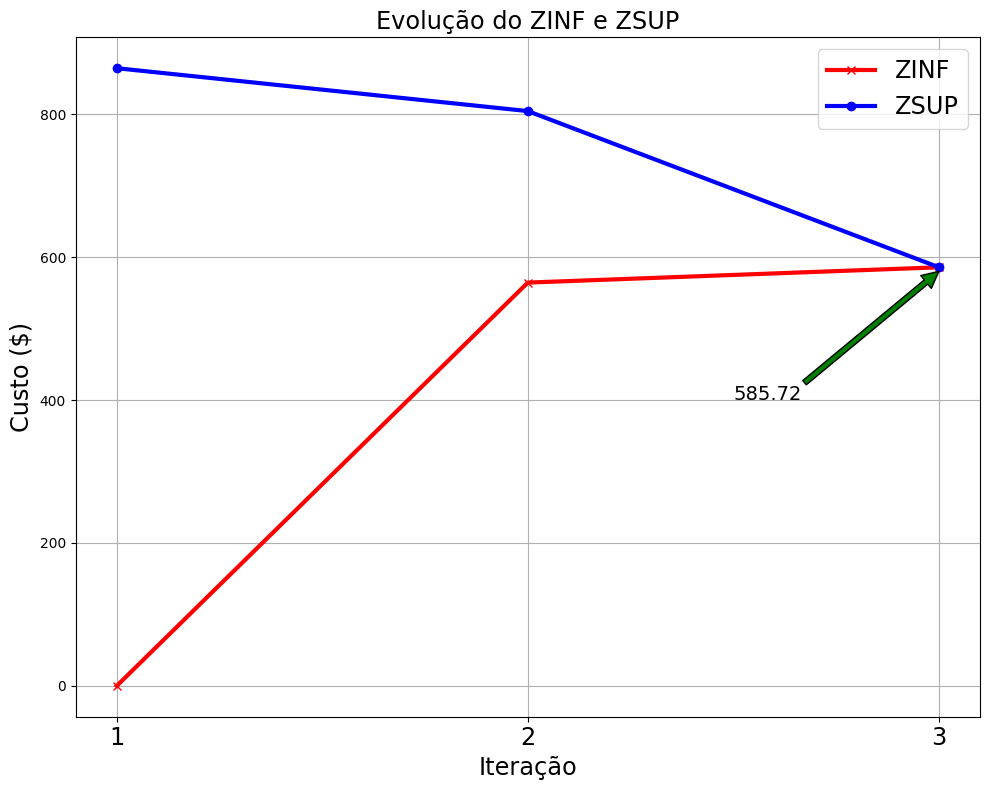

In [17]:
## Gráfico de Convergência da PDDD
# Mostra evolução do ZINF e ZSUP
x = np.arange(0,resultado_pddd["DGer"]["Nr_Iteracoes"]+1,1)
plt.figure(figsize=(10,8))

plt.plot(x+1, resultado_pddd["DGer"]["ZINF"] ,'red', marker='x', linewidth=3.0, label="ZINF")
plt.plot(x+1, resultado_pddd["DGer"]["ZSUP"] ,'blue', marker='o', linewidth=3.0, label="ZSUP")

plt.legend(fontsize="xx-large")
plt.title('Evolução do ZINF e ZSUP',fontsize="xx-large")
plt.xlabel('Iteração',fontsize="xx-large")
plt.ylabel('Custo ($)',fontsize="xx-large")
plt.xticks(x+1,fontsize="xx-large")
plt.grid()
plt.tight_layout()
plt.annotate('585.72', xy=(3, 580), xytext=(2.5, 400), fontsize=14,
            arrowprops=dict(facecolor='green', shrink=5))


plt.show()

# Plota Gráfico Comparativos dos Métodos

In [18]:
realizar_plot = 'Nao'
if realizar_plot == 'Sim':
  # Análise de estagnação dos resultados mediante discretização
  discretizacoes = 80
  resultado_pdd_matriz = {}
  custo = np.zeros((discretizacoes,))
  disc = np.zeros((discretizacoes,))
  temp = np.zeros((discretizacoes,))
  kk = 0;

  for num1 in range(discretizacoes):
    d_gerais['Nr_Disc'] = num1+3
    #print('Discretização:', d_gerais['Nr_Disc'])
    inicio = time.time()
    resultado_pdd_matriz[num1] = pdd(sistema, 0, imprime=False)
    if (resultado_pdd_matriz[num1]['DGer']['CustoTotal']) != 0:
      disc[kk] = d_gerais['Nr_Disc']
      custo[kk] = resultado_pdd_matriz[num1]['DGer']['CustoTotal']
      temp[kk] = time.time() - inicio
      #print('Resultado: ',resultado_pdd_matriz[kk]['DGer'])
      kk = kk + 1

In [19]:
if realizar_plot == 'Sim':
  # tempo com a discretização
  cont = 0
  for num1 in range(len(custo)):
    if resultado_pdd_matriz[num1]['DGer']['CustoTotal'] != 0:
      cont = cont +1
  plt.figure(figsize=(10,8))
  plt.plot(disc[:cont],temp[:cont],color='red')
  plt.title('Tempo total de acordo com a discretização - PDD',fontsize="xx-large")
  plt.xlabel('Discretização',fontsize="xx-large")
  plt.ylabel('Tempo Total [segundos]',fontsize="xx-large")
  plt.grid()
  plt.tight_layout()
  plt.show()

In [20]:
if realizar_plot == 'Sim':
  # Custo total pela discretização
  cont = 0
  for num1 in range(len(custo)):
    if resultado_pdd_matriz[num1]['DGer']['CustoTotal'] != 0:
      cont = cont +1
  plt.figure(figsize=(10,8))
  plt.plot(disc[:cont],custo[:cont],color='red')
  plt.title('Custo total de acordo com a discretização - PDD',fontsize="xx-large")
  plt.xlabel('Discretização',fontsize="xx-large")
  plt.ylabel('Custo Total',fontsize="xx-large")
  plt.grid()
  plt.tight_layout()
  plt.show()

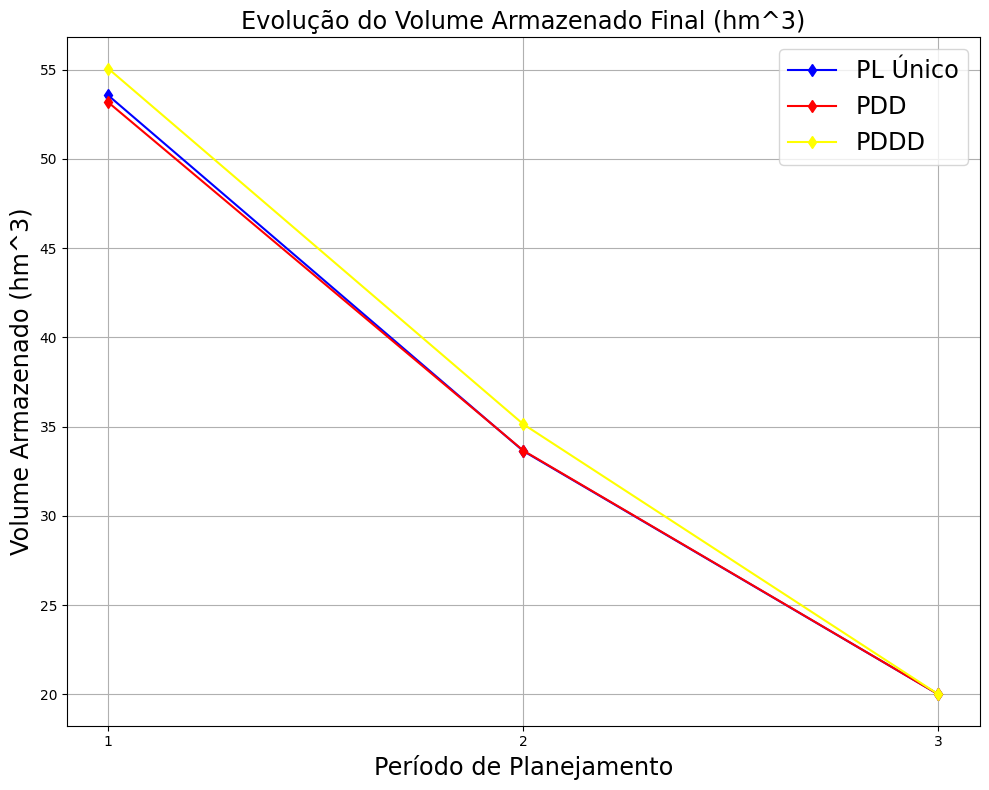

In [21]:
# Volume armazenado final de cada estágio
x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

for i, iusi in enumerate(resultado_pl["UHE"]):
  plt.plot(x+1, iusi['vf'] , marker='d',color='blue')
for i, iusi in enumerate(resultado_pdd["UHE"]):
  plt.plot(x+1, iusi['vf'] , marker='d',color='red')
for i, iusi in enumerate(resultado_pddd["UHE"]):
  plt.plot(x+1, iusi['vf'] , marker='d',color='yellow')

plt.title('Evolução do Volume Armazenado Final (hm^3)',fontsize="xx-large")
plt.xlabel('Período de Planejamento',fontsize="xx-large")
plt.ylabel('Volume Armazenado (hm^3)',fontsize="xx-large")
plt.legend(['PL Único','PDD','PDDD'],fontsize="xx-large")
plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.show()

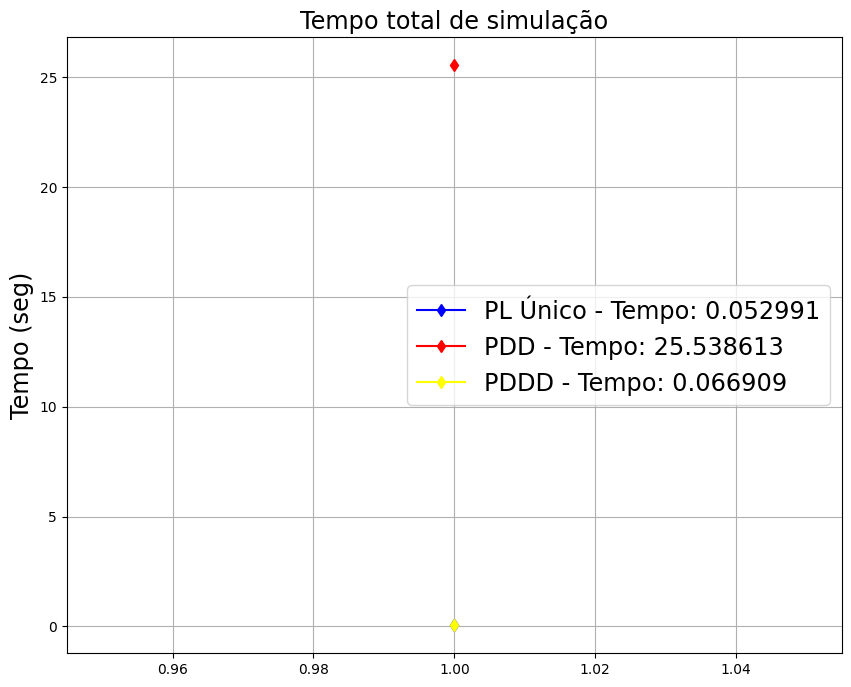

In [22]:
# Tempo total
x = 0
plt.figure(figsize=(10,8))

plt.plot(x+1, tempo_pl, marker='d', color = 'blue')
plt.plot(x+1, tempo_pdd, marker='d', color = 'red')
plt.plot(x+1, tempo_pddd, marker='d', color = 'yellow')


plt.title('Tempo total de simulação',fontsize="xx-large")
#plt.xlabel('')
plt.ylabel('Tempo (seg)',fontsize="xx-large")
plt.grid()
#plt.tight_layout()
st_pdd = str(round(tempo_pdd,6))
st_pl = str(round(tempo_pl,6))
st_pddd = str(round(tempo_pddd,6))

plt.legend(['PL Único - Tempo: '+st_pl,'PDD - Tempo: '+st_pdd,'PDDD - Tempo: '+st_pddd],fontsize="xx-large")
plt.show()

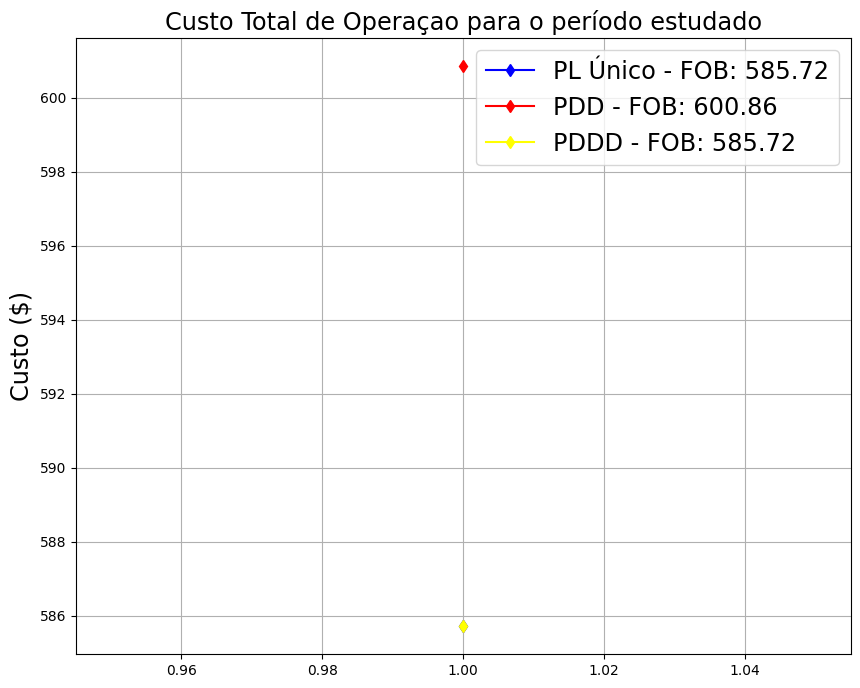

In [23]:
# Custo Total PL Única, PDD e PDDD
x = 0
plt.figure(figsize=(10,8))

plt.plot(x+1, CustoTotal_PL, marker='d', color = 'blue')
plt.plot(x+1, CustoTotal_PDD, marker='d', color = 'red')
plt.plot(x+1, CustoTotal_PDDD, marker='d', color = 'yellow')


plt.title('Custo Total de Operaçao para o período estudado',fontsize="xx-large")
#plt.xlabel('')
plt.ylabel('Custo ($)',fontsize="xx-large")
plt.grid()
#plt.tight_layout()
st_pdd = str(round(CustoTotal_PDD,2))
st_pl = str(round(CustoTotal_PL,2))
st_pddd = str(round(CustoTotal_PDDD,2))

plt.legend(['PL Único - FOB: '+st_pl,'PDD - FOB: '+st_pdd,'PDDD - FOB: '+st_pddd],fontsize="xx-large")
plt.show()

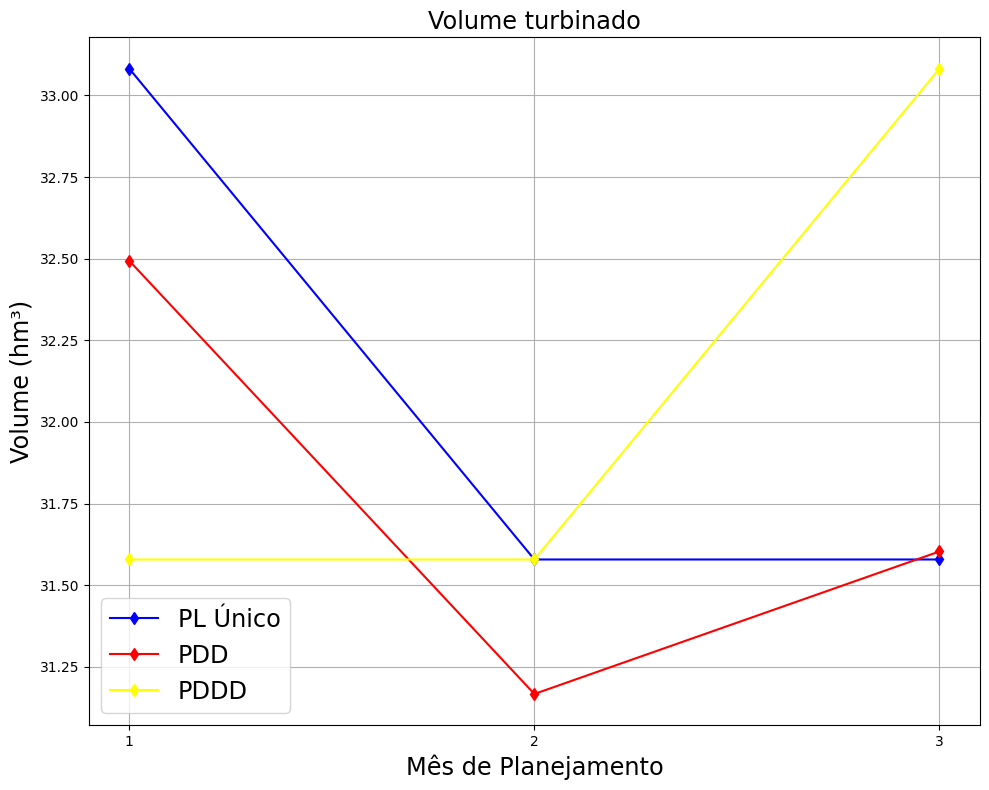

In [24]:
# Volume turbinado em cada estágio
x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

for i, iusi in enumerate(resultado_pl["UHE"]):
  plt.plot(x+1, iusi['vt'] , marker='d',color='blue')
for i, iusi in enumerate(resultado_pdd["UHE"]):
  plt.plot(x+1, iusi['vt'] , marker='d',color='red')
for i, iusi in enumerate(resultado_pddd["UHE"]):
  plt.plot(x+1, iusi['vt'] , marker='d',color='yellow')

plt.title('Volume turbinado',fontsize="xx-large")
plt.xlabel('Mês de Planejamento',fontsize="xx-large")
plt.ylabel('Volume (hm³)',fontsize="xx-large")
plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.legend(['PL Único', 'PDD','PDDD'],fontsize="xx-large")
plt.show()

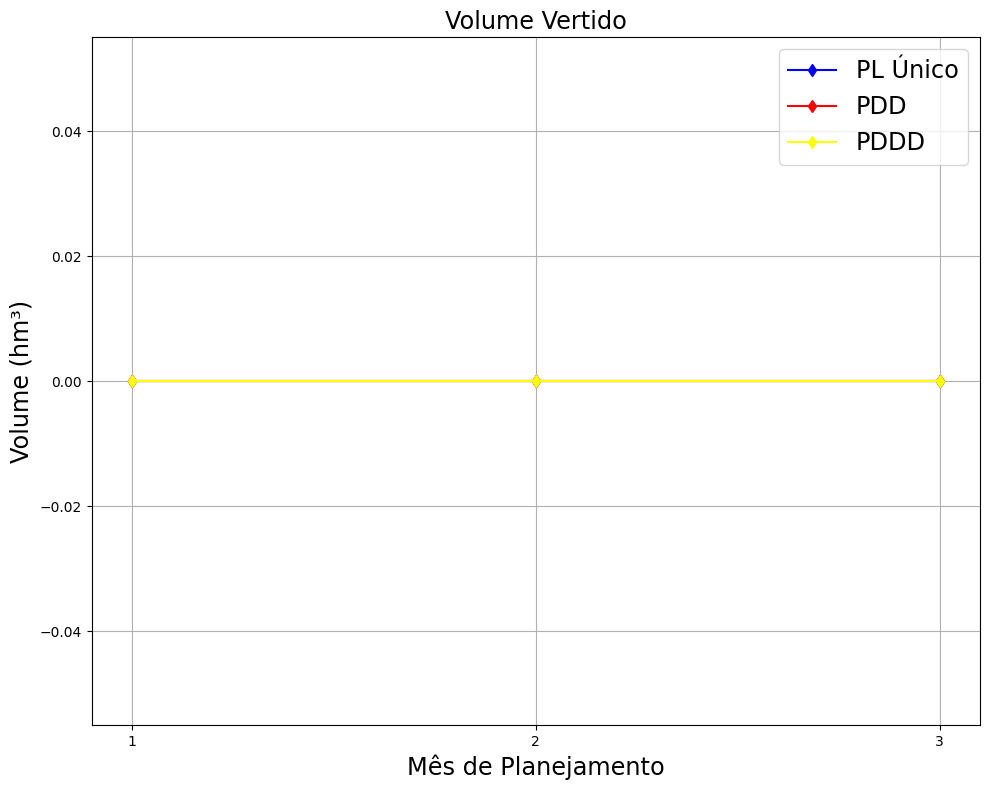

In [25]:
# Volume vertido em cada estágio
x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

for i, iusi in enumerate(resultado_pl["UHE"]):
  plt.plot(x+1, iusi['vv'] , marker='d',color='blue')
for i, iusi in enumerate(resultado_pdd["UHE"]):
  plt.plot(x+1, iusi['vv'] , marker='d',color='red')
for i, iusi in enumerate(resultado_pddd["UHE"]):
  plt.plot(x+1, iusi['vv'] , marker='d',color='yellow')

plt.title('Volume Vertido',fontsize="xx-large")
plt.xlabel('Mês de Planejamento',fontsize="xx-large")
plt.ylabel('Volume (hm³)',fontsize="xx-large")
plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.legend(['PL Único', 'PDD', 'PDDD'],fontsize="xx-large")
plt.show()

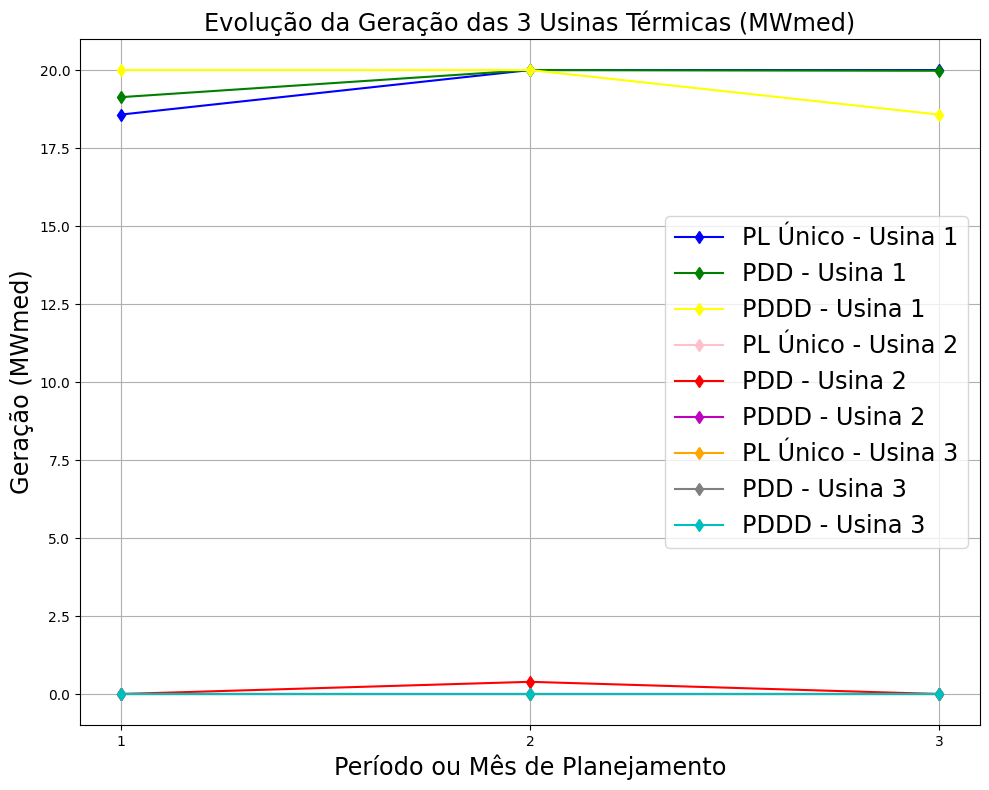

In [26]:
# Geração das Térmicas
x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

gt1_pl = resultado_pl['UTE'][0]['gt']
gt1_pdd = resultado_pdd['UTE'][0]['gt']
gt1_pddd = resultado_pddd['UTE'][0]['gt']
gt2_pl = resultado_pl['UTE'][1]['gt']
gt2_pdd = resultado_pdd['UTE'][1]['gt']
gt2_pddd = resultado_pddd['UTE'][1]['gt']
gt3_pl = resultado_pl['UTE'][2]['gt']
gt3_pdd = resultado_pdd['UTE'][2]['gt']
gt3_pddd = resultado_pddd['UTE'][2]['gt']

plt.plot(x+1,gt1_pl, marker='d',color='blue')
plt.plot(x+1,gt1_pdd, marker='d',color='green')
plt.plot(x+1,gt1_pddd, marker='d',color='yellow')
plt.plot(x+1,gt2_pl, marker='d',color='pink')
plt.plot(x+1,gt2_pdd, marker='d',color='red')
plt.plot(x+1,gt2_pddd, marker='d',color='m')
plt.plot(x+1,gt3_pl, marker='d',color='orange')
plt.plot(x+1,gt3_pdd, marker='d',color='grey')
plt.plot(x+1,gt3_pddd, marker='d',color='c')


plt.title('Evolução da Geração das 3 Usinas Térmicas (MWmed)',fontsize="xx-large")
plt.xlabel('Período ou Mês de Planejamento',fontsize="xx-large")
plt.ylabel('Geração (MWmed)',fontsize="xx-large")
plt.legend(['PL Único - Usina 1', 'PDD - Usina 1', 'PDDD - Usina 1','PL Único - Usina 2', 'PDD - Usina 2','PDDD - Usina 2','PL Único - Usina 3', 'PDD - Usina 3','PDDD - Usina 3'],fontsize="xx-large")
plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.show()